In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Concatenate, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### DGP

Generate some data for exploration of different neural network architectures.

$y_{t+1}$ is generated by the common factors $f_t$ of the regressors plus an additional term $z_t$ consisting of $p$ variables of the predictor space. The latter captures individual effect of the regressors on $y_t$

\begin{align*}
    f_t &= \phi f_{t-1} + \eta_t, \\
    x_t &= \Lambda f_t + e_t, \\
    y_{t+1} &= \gamma f_t + z_t \beta + u_{t+1}.
\end{align*}

In [2]:
def dgp(T, n, r, p, d, gamma, beta, corr2_xf, corr2_yf, seed):

    """
    generates data from a factor model
    
    arguments:
    
    param T: number of observations
    param n: number of regressors
    param r: number of factors
    param p: number of additional regressors in forecasting equation
    param d: eigenvalues of the covariance matrix of X
    param gamma: factor loading on forecasting target
    param beta: coefficients of additional regressors in forecasting equation
    param corr2_xf: tuple of R^2 between x1, x2, ..., xn and f
    param corr2_yf: R^2 between y and f
    return:
    """

    F = np.zeros((T, r))
    X = np.zeros((T, n))
    e = np.zeros((T, n))

    np.random.seed(seed)
    
    # === loading matrix Lambda === #
    
    D = np.diag(d)
    A = np.random.randn(n, n)
    _, V = np.linalg.eigh(1 / 1 * A.T @ A)
    V = np.fliplr(V)[:, :r]
    Lambda = V @ np.sqrt(D)
    
    # === settings AR-process for f === #
    
    Phi = np.diag([0.9] * r)
    
    # === error variances === #
    
    cov_xf = Lambda  # x's in rows, correlation with f's in columns
    sig2_e = cov_xf @ cov_xf.T * np.linalg.inv(np.diag(corr2_xf)) - (
        np.diag(np.diag(Lambda @ Lambda.T)))

    cov_yf = gamma
    sig2_u = cov_yf @ cov_yf.T / corr2_yf - (
        gamma @ gamma.T)
    
    # === error process for e === #
    
    """
    The error process is assumed to be weakly
    cross- and serially-correlated.
    """
    
    rho = 0.2  # auto-correlation
    beta_error = 0.2 # cross-correlation
    J = int(np.ceil(n / 20))  # number of cross-correlated errors
    
    c = np.sqrt((1 + 2 * J * beta_error**2) / ((1 - rho**2) * np.diag(sig2_e)))  
    
    """
    c is a normalizing constant 
    to get the specified error variance
    """
    
    # === Initialization === #
    
    F[[int(-T/2)], :] = np.random.multivariate_normal([0] * r, np.eye(r), 1)
    e[int(-T / 2), :] = 1/c * (np.random.multivariate_normal([0] * n,
                                                      np.eye(n) * (1 + 2 * J * beta_error ** 2) / (1 - rho ** 2), 1))
    X[int(-T/2), :] = F[[int(-T/2)], :] @ Lambda.T + 1/c * e[[0], :]
    
    # === Simulation === #
    
    eta = np.random.multivariate_normal([0] * r, np.eye(r) - Phi**2, T)
    nu = np.random.multivariate_normal([0] * n, np.diag(np.ones(n)), T)
    
    for i in range(int(-T/2)+1, T):
        F[i, :] = Phi @ F[i-1, :] + eta[i, :]
        for j in range(0, n):
            cross_list_ = 3 * [ii for ii in range(0, n)]
            cross_list = cross_list_[n+j-J: n+j+J+1]
            cross_list.remove(j)
            e[i, j] = 1/c[j] * (rho * e[i - 1, j] + nu[i, j] + np.sum(beta_error * nu[i, cross_list]))
        X[i, :] = F[[i], :] @ Lambda.T + e[[i], :]

    z = np.random.choice(np.arange(0, n), size=p, replace=False)
    y = X[:, z] @ beta + F @ gamma.T + np.sqrt(sig2_u) * np.random.randn(T, 1)

    return X, y, F, Lambda, sig2_u, sig2_e, e, c

In [3]:
T = 200 # number of samples / length of time series
n = 30  # number of regressor variables
s = 5   # decay constant of the eigenvalues of the covariance matrix of X
        # governs the importance of common factors in the the predictor space
r = 8   # number of factors
p = int(n/2)

d = np.exp(-s * np.arange(1, r + 1) / r)
d = d / np.linalg.norm(d)

gamma = np.atleast_2d(d)
gamma = np.sqrt(sum(d) / n) * gamma / np.linalg.norm(gamma) # normalization

beta = np.ones((p, 1))
beta = np.sqrt(p / n) * beta / np.linalg.norm(beta) # normalization

corr2_xf = (0.8,) * n  # correlation between factors and X
corr2_yf = 0.8         # correlation between factors and y

seed = 123

X, y, _, _, _, _, _, _ = dgp(T, n, r, p, d, gamma, beta, corr2_xf, corr2_yf, seed)

### Multilayer Perceptron Network (MLP)

In [4]:
# ======================= #
# === build the model === #
# ======================= #

# specify model input
input_layer = Input(shape=(n, ))  # n: number of input variables

# specify hidden layers
h_0 = Dense(10, activation='relu')(input_layer)  # defines a densely connected hidden layer of 10 neurons
                                                 # layer takes the input "input_layer" and returns "h_0"

h_0 = Dropout(0.2)(h_0)  # dropout applied to hidden layer h_0

layer_1 = Dense(2, activation='relu')  # Alternative code to specify a hidden layer
h_1 = layer_1(h_0)

# define model output
output_layer = Dense(1, activation='linear')(h_1)

# create a model of the previously defined layers
model = Model(inputs=input_layer, outputs=output_layer)

# ========================= #
# === compile the model === #
# ========================= #

model.compile(optimizer='ADAM',
             loss='mse',
             metrics=['mse'])

# ======================= #
# === train the model === #
# ======================= #

# specify an early stopping rule
es = EarlyStopping(monitor='val_loss',         # metric to be monitored
                   mode='min',                 # whether min or max is seeked
                   patience=200,               # addional epoch after stopping rule was hit
                   restore_best_weights=True,  # restore weights from the best epoch
                   verbose=1)                  # print epoch number
# model training
history = model.fit(X[:160, :], y[:160, :], 
                    epochs=5000,               # a full run through all training sets, i.e. all batches,
                                               # determines one epoch
                    batch_size=80,             # model weights are updated after each batch
                    validation_split = 0.2,    # fraction used as validation data (uses the last samples)
                    #validation_data=(X[128:, :], y[128:, :]), # Alternatively, select validation data manually
                    callbacks=[es],            # early stopping rule
                    verbose=0)                 # suppress to print every epoch iteration

Restoring model weights from the end of the best epoch
Epoch 00812: early stopping


#### Evaluation of Model Training

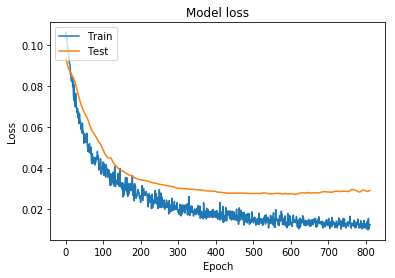

In [5]:
# === Plot training & validation loss === #

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(['Train', 'Test'], loc='upper left')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [6]:
# === evaluate model performance on given dataset (X, y) === #

for i, metrics in enumerate(model.metrics_names):
    print('{0}: {1}'.format(metrics, model.evaluate(X, y, verbose=0)[i]))

# === get weights of model layers === #

weights_2 = layer_1.get_weights()  # directly calling layer_2
weights_2 = model.layers[1].get_weights()  # via model

loss: 0.015561282262206077
mean_squared_error: 0.015561282262206077


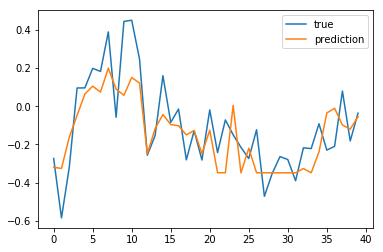

In [7]:
# === make predictions === #

y_hat = model.predict(X[-40:, :])

fig, ax = plt.subplots()
ax.plot(y[-40:, :], label='true')
ax.plot(y_hat[-40:, :], label='prediction')
ax.legend()
plt.show()

### Recurrent Neural Network

#### Input Data Preparation

RNNs require the input data to be of shape:

$[\text{number of samples}, \text{number of time steps}, \text{number of features}]$

- *features*: the n variables.

- *time steps*: lags of the the input variables.

- *samples*: every ''row'' in the dataset can be seen as one sample.

##### Consider the following example how data have to be prepared for a univariate RNN:

Given sequence of datapoints in time:

$[10, 20, 30, 40, 50, 60, 70, 80, 90]$

This sequence has to be transformed into multiple input/outout patterns (i.e. samples):

\begin{align*}
    &X \qquad \qquad \quad Y \\
    &[10, 20, 30] \qquad [40] \\
    &[20, 30, 40] \qquad [50] \\
    &\ldots \\
    &[60, 70, 80] \qquad [90] 
\end{align*}

We get six samples each with 3 input time steps (i.e. lags) and one output time step.

RNNs require the input data to be of shape:

$[\text{number of samples}, \text{number of time steps}, \text{number of features}]$

Here:
$[6, 3, 1]$

As a univariate series is considered, the number of features is one.

#### Define a function that prepares the input data for RNN and CNN

In [8]:
def split_sequences(seq_x, t_steps, *seq_y, lag0=False):
    
    """
    Transforms the dataset in input/output samples that have the shape required for RNN and CNN.
    [samples, timesteps, features]
    
    seq_x: regressor time series
    t_steps: number of lags
    lag0: if True, current values are used as the first time step
    seq_y (optional): specify when forecasting target differs from regressors, i.e. no AR-Model.
    """
    
    T, N = seq_x.shape
    N_y = N if not seq_y else seq_y[0].shape[1]
    lag0 = 1 if lag0 == True else 0
    
    X = np.zeros((T - t_steps + lag0, t_steps, N))
    Y = np.zeros((T - t_steps + lag0, N_y))

    for i in range(T):
        
        end_ix = i + t_steps
        # check if beyond the sequence
        if end_ix >= T + lag0:
            break
        # gather input and output parts
        X[[i], :, :] = seq_x[i:end_ix, :]
        Y[[i], :] = seq_x[[end_ix - lag0], :] if not seq_y else seq_y[0][[end_ix - lag0], :]
        
    return X, Y

In [9]:
# ================================ #
# === prepare data for a model === #
# ================================ #

t_steps = 4
lag0 = True
q = 0 if lag0==False else 1
n_features = X.shape[1]
    
X_train, y_train = split_sequences(X[:160, :], t_steps, y[:160, :], lag0=True)
X_test, y_test = split_sequences(X[160 - t_steps + q:, :], t_steps, y[160 - t_steps + q:, :], lag0=lag0)

#### Build an RNN

In [10]:
# ======================= #
# === build the model === #
# ======================= #

# specify model input
input_layer = Input(shape=(t_steps, n_features))  # shape = (number of time steps, number of features)

# specify hidden layers
h_0 = Dense(n, activation='relu')(input_layer)  # a standard densely connected layer
h_0 = Dropout(0.2)(h_0)  # dropout applied to layer_0

# recurrent layer
h_1 = LSTM(5)(h_0)  #  add an LSTM cell with hidden size = 2

# define model output
output_layer = Dense(1)(h_1)

# create a model of the previously defined layers
model = Model(inputs=input_layer, outputs=output_layer)

# ========================= #
# === compile the model === #
# ========================= #

model.compile(optimizer='ADAM',
             loss='mse',
             metrics=['mse'])

# ======================= #
# === train the model === #
# ======================= #

# specify an early stopping rule
es = EarlyStopping(monitor='val_loss',         # metric to be monitored
                   mode='min',                 # whether min or max is seeked
                   patience=200,               # addional epoch after stopping rule was hit
                   restore_best_weights=True,  # restore weights from the best epoch
                   verbose=1)                  # print epoch number
# model training
history = model.fit(X_train, y_train, 
                    epochs=5000,               # a full run through all training sets, i.e. all batches,
                                               # determines one epoch
                    batch_size=80,             # model weights are updated after each batch
                    validation_split = 0.2,    # fraction used as validation data (uses the last samples)
                    #validation_data=(X[128:, :], y[128:, :]), # Alternatively, select validation data manually
                    callbacks=[es],            # early stopping rule
                    verbose=0)      

Restoring model weights from the end of the best epoch
Epoch 00497: early stopping


#### Evaluation of Model Training

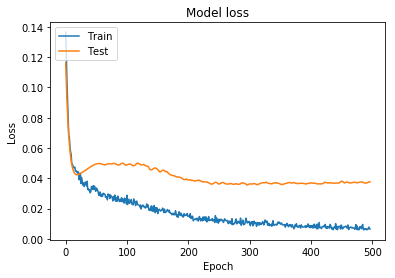

In [11]:
# === Plot training & validation loss === #

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(['Train', 'Test'], loc='upper left')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

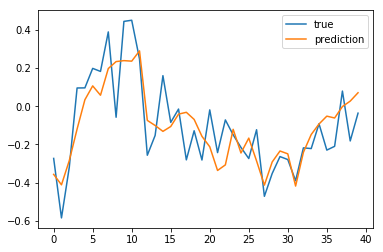

In [12]:
# === make predictions === #

y_hat = model.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test, label='true')
ax.plot(y_hat, label='prediction')
ax.legend()
plt.show()

### Convolutional Neural Network

Same as for RNN, the input data for a CNN require to have the shape:

$[samples, timesteps, features]$

In [13]:
# ================================ #
# === prepare data for a model === #
# ================================ #

t_steps = 8
lag0 = True
q = 0 if lag0==False else 1
n_features = X.shape[1]
    
X_train, y_train = split_sequences(X[:160, :], t_steps, y[:160, :], lag0=True)
X_test, y_test = split_sequences(X[160 - t_steps + q:, :], t_steps, y[160 - t_steps + q:, :], lag0=lag0)

#### Build an Convolutional Neural Network

A one-dimensional CNN has a convolutional hidden layer that operates over a 1D sequence, and then a pooling layer whose job is to distill the output of the convolutional layer to the most salient elements.

Note that the kernel slides over the timesteps. Example: for kernel_size=3 and n_steps=8 the number of "timesteps" is reduced to 6. Hence, the maximum pool_size would be 6.

In [14]:
# ======================= #
# === build the model === #
# ======================= #

# specify model input
input_layer = Input(shape=(t_steps, n_features))  # shape = (number of time steps, number of features)

# specify hidden layers
conv_layer = Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(t_steps, n_features))(input_layer)

pool_layer = MaxPooling1D(pool_size=4)(conv_layer)

flatten_layer = Flatten()(pool_layer)

# define model output
output_layer = Dense(1)(flatten_layer)

# create a model of the previously defined layers
model = Model(inputs=input_layer, outputs=output_layer)

# ========================= #
# === compile the model === #
# ========================= #

model.compile(optimizer='ADAM',
             loss='mse',
             metrics=['mse'])

# ======================= #
# === train the model === #
# ======================= #

# specify an early stopping rule
es = EarlyStopping(monitor='val_loss',         # metric to be monitored
                   mode='min',                 # whether min or max is seeked
                   patience=200,               # addional epoch after stopping rule was hit
                   restore_best_weights=True,  # restore weights from the best epoch
                   verbose=1)                  # print epoch number
# model training
history = model.fit(X_train, y_train, 
                    epochs=5000,               # a full run through all training sets, i.e. all batches,
                                               # determines one epoch
                    batch_size=80,             # model weights are updated after each batch
                    validation_split = 0.2,    # fraction used as validation data (uses the last samples)
                    #validation_data=(X[128:, :], y[128:, :]), # Alternatively, select validation data manually
                    callbacks=[es],            # early stopping rule
                    verbose=0)      

Restoring model weights from the end of the best epoch
Epoch 00825: early stopping


#### Evaluation of Model Training

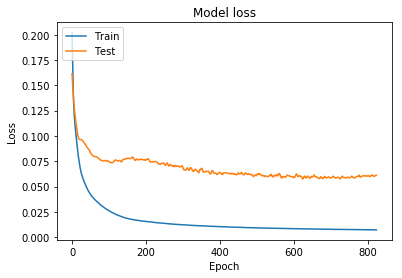

In [15]:
# === Plot training & validation loss === #

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(['Train', 'Test'], loc='upper left')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

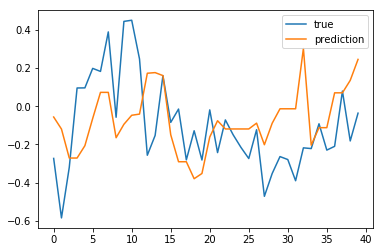

In [16]:
# === make predictions === #

y_hat = model.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test, label='true')
ax.plot(y_hat, label='prediction')
ax.legend()
plt.show()

### Multi-branch networks

In [17]:
# ======================= #
# === build the model === #
# ======================= #

# specify model inputs

# different branches for inputs A and B
input_layer_A = Input(shape=(int(n/2), ))
input_layer_B = Input(shape=(n - int(n/2), ))

# specify hidden layers

# for branch A
h_0_A = Dense(int(n/2), activation='relu')(input_layer_A)  # a layer instance is callable on a tensor
h_0_A = Dropout(0.5)(h_0_A)  # dropout is applied to the previous layer

# for branch B
h_0_B = Dense(3, activation='relu')(input_layer_B)  # a layer instance is callable on a tensor
h_0_B = Dropout(0.2)(h_0_B)  # dropout is applied to the previous layer

# concatenate both branches
h_1 = Concatenate(axis=1)([h_0_A, h_0_B])

# just another (common) hidden layer
h_2 = Dense(2, activation='relu')(h_1)

# define model output
output_layer = Dense(1, activation='linear')(h_2)

# create a model of the previously defined layers
model = Model(inputs=[input_layer_A, input_layer_B], outputs=output_layer)

# ========================= #
# === compile the model === #
# ========================= #

model.compile(optimizer='ADAM',
             loss='mse',
             metrics=['mse'])

# ======================= #
# === train the model === #
# ======================= #

# specify an early stopping rule
es = EarlyStopping(monitor='val_loss',         # metric to be monitored
                   mode='min',                 # whether min or max is seeked
                   patience=200,               # addional epoch after stopping rule was hit
                   restore_best_weights=True,  # restore weights from the best epoch
                   verbose=1)                  # print epoch number
# model training
history = model.fit([X[:160, :int(n/2)], X[:160, n - int(n/2):]], y[:160, :], 
                    epochs=5000,               # a full run through all training sets, i.e. all batches,
                                               # determines one epoch
                    batch_size=80,             # model weights are updated after each batch
                    validation_split = 0.2,    # fraction used as validation data (uses the last samples)
                    #validation_data=(X[128:, :], y[128:, :]), # Alternatively, select validation data manually
                    callbacks=[es],            # early stopping rule
                    verbose=0)                 # suppress to print every epoch iteration

Restoring model weights from the end of the best epoch
Epoch 01169: early stopping


#### Evaluation of Model Training

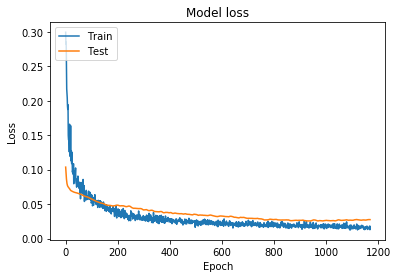

In [18]:
# === Plot training & validation loss === #

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(['Train', 'Test'], loc='upper left')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

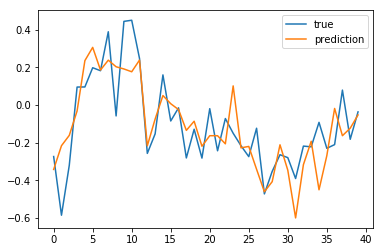

In [19]:
# === make predictions === #

y_hat = model.predict([X[-40:, :int(n/2)], X[-40:, n - int(n/2):]])

fig, ax = plt.subplots()
ax.plot(y[-40:, :], label='true')
ax.plot(y_hat[-40:, :], label='prediction')
ax.legend()
plt.show()